# Financial Data Visualization

Going through the process of linear regression, which is in itself the simplest form of Gradient Descent on some data pulled from Financial Sites and using matplotlib to visualize some concepts for myself 

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np
from pandas_datareader import data 
import quandl
from tiingo import TiingoClient
import config
import cvxopt as opt
from cvxopt import blas, solvers
pd.options.display.float_format = '{:.2f}'.format

E:\Work\Python\lib\site-packages\pandas_datareader\compat\__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [6]:
quandl.ApiConfig.api_key = config.QuandlKey

In [7]:
fred_gdp = quandl.get("FRED/GDP")
print(fred_gdp.head())
print(fred_gdp.index)

            Value
Date             
1947-01-01 243.16
1947-04-01 245.97
1947-07-01 249.59
1947-10-01 259.75
1948-01-01 265.74
DatetimeIndex(['1947-01-01', '1947-04-01', '1947-07-01', '1947-10-01',
               '1948-01-01', '1948-04-01', '1948-07-01', '1948-10-01',
               '1949-01-01', '1949-04-01',
               ...
               '2017-10-01', '2018-01-01', '2018-04-01', '2018-07-01',
               '2018-10-01', '2019-01-01', '2019-04-01', '2019-07-01',
               '2019-10-01', '2020-01-01'],
              dtype='datetime64[ns]', name='Date', length=293, freq=None)


Text(0, 0.5, 'GDP')

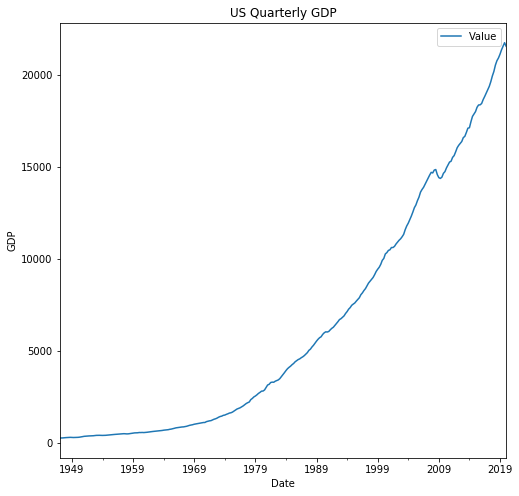

In [8]:
fred_gdp.plot(figsize = (8,8))
plt.title('US Quarterly GDP')
plt.ylabel('GDP')

In [9]:
start = datetime(2010,1,1)
end = datetime(2021,1,1)
oil_data = quandl.get("EIA/PET_RWTC_D",  start_date = start, end_date = end)
print(oil_data)

            Value
Date             
2010-01-04  81.52
2010-01-05  81.74
2010-01-06  83.12
2010-01-07  82.60
2010-01-08  82.74
...           ...
2020-04-28  12.40
2020-04-29  15.04
2020-04-30  19.23
2020-05-01  19.72
2020-05-04  20.47

[2618 rows x 1 columns]


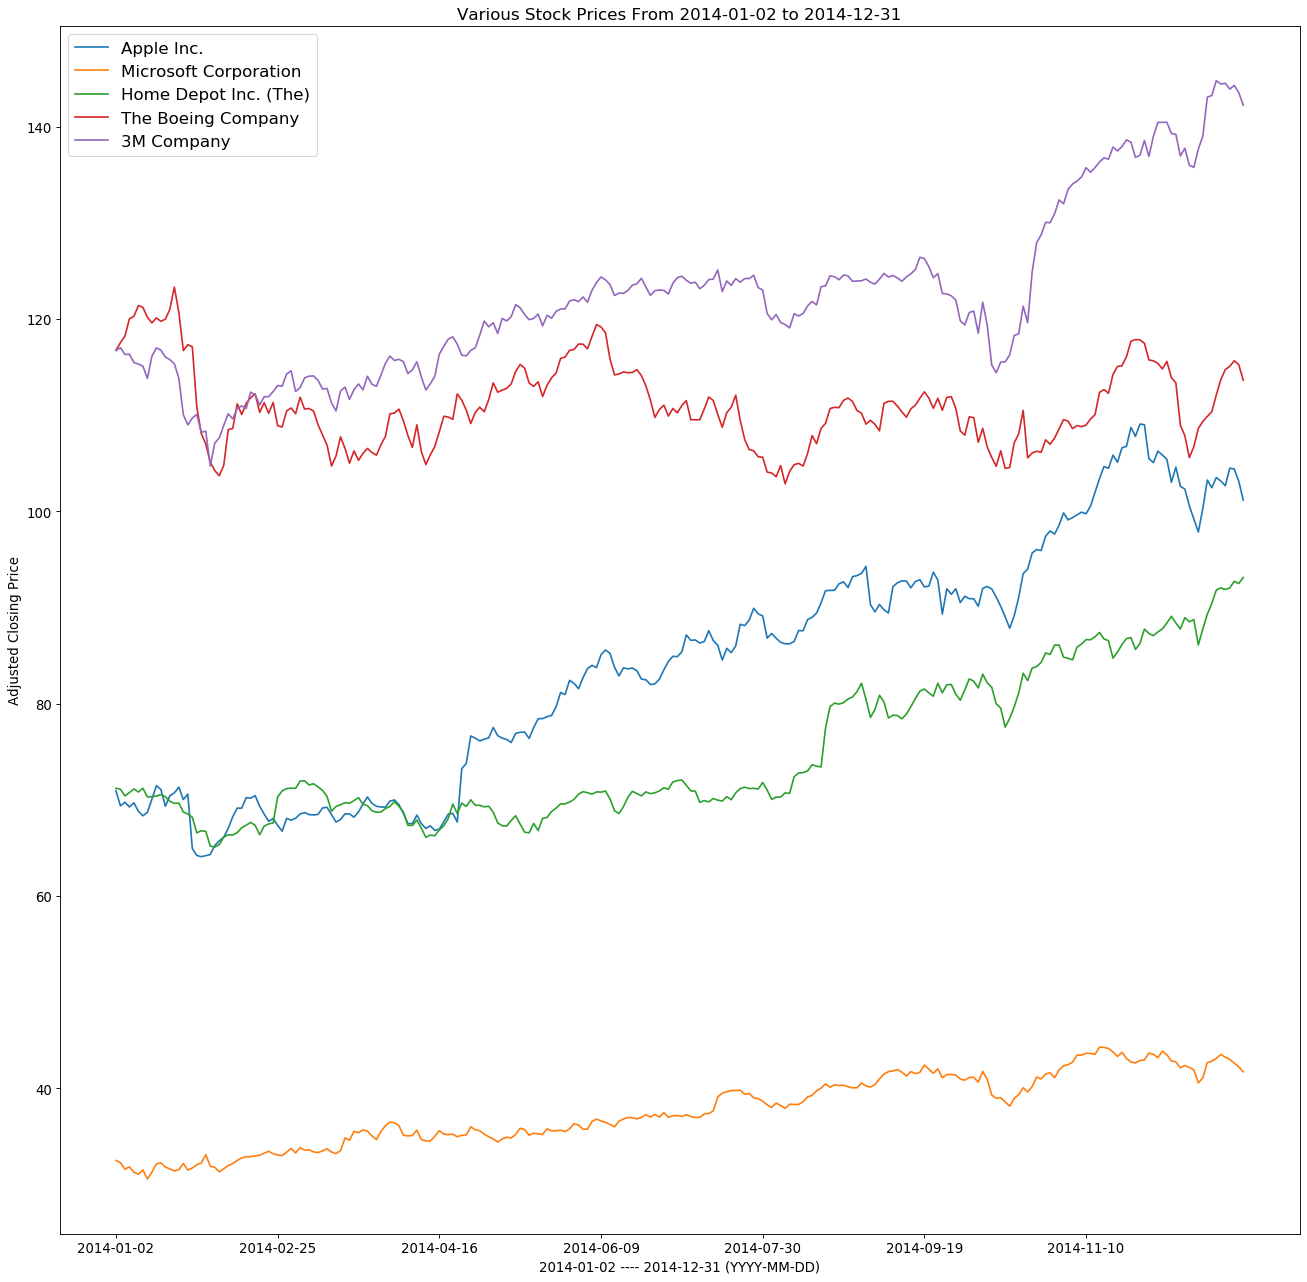

In [79]:
Q_ticker_list = pd.read_csv('csv/Quandl_ticker_list.csv')

def quandlRow(ticker):
    x = Q_ticker_list[Q_ticker_list.Ticker == ticker].reset_index(drop = True)
    if x.empty:
        print('Error: Ticker: {} could not be found'.format(ticker))
    return x

def quandlCode(ticker: str)->str:
    x = quandlRow(ticker)
    if x.empty:
        return None
    else:
        return(x['Quandl_Code'][0])
    
    
def quandleName(ticker: str)->str:
    x = quandlRow(ticker)
    if x.empty:
        return None
    else:
        return(x['Name'][0])
    
    
#return List of tuples
#tuple format: (ticker, quandlCode, quandlName)
#if given ticker is poorly formated will not append, print issue in quandlRow
#duplicates are removed
def getSymbols(tickers):
    list(set(tickers))
    r = []
    for t in tickers:
        x = quandlCode(t)
        if x != None:
            temp = (t,x,quandleName(t))
            r.append(temp)
    return r    
        
        
# take in a list of tickers (start_date and end_date optional), and retrieve the given dataframes into a list
# indexed by the date, with multi level columns keys are the tickers given
# if poorly formated tickers are given will print error, but will continue adding all correctly formated tickers
# Utilizing free stock data from quandl 
# possible ticker given is unaviable within free sample will silently omit
def aggregateStockData(tickers, start_date = None, end_date = None, collapse = None):
    
    syms = getSymbols(tickers)
    dfList = []
    keyList = []
    n = ['Companies', 'Data']
    
    if len(syms) == 0:
        return None, None
    for s in syms:
        try:
            df = quandl.get(s[1], start_date = start_date, end_date = end_date, collapse = collapse)
            df = df.loc[~df.index.duplicated(keep='first')]
            dfList.append(df)
            keyList.append(s[2])
        except:
            print('Quandl Free Sample does not have data on ticker: {}'.format(s[0]))
    
    if len(dfList) == 0:
        return None, None
    return dfList,keyList
        

    
def plotStockData(tickers, start_date = None, end_date = None, separate = True):
    dframes, keyList = aggregateStockData(tickers,start_date = start_date, end_date = end_date)

    def calcDim(amount):
        if amount == 1:
            c = 1 
            r = 1
            return r,c
        if amount <= 4:
            c = 2 
            r = 2
            return r,c
        root = amount**0.5
        x = round(root)
        c = x
        r = 0
        if root > x:
            r = x + 1
        else: 
            r = x
        return r,c
    def processTimeStamp(x):
        year = x.isocalendar()[0]
        month = x.month_name()

        return x.date()

    def getxtickLabels(df, numTicks):
        numEntries = len(df.index)
        r = []
        for i in range(0,numEntries,int(numEntries/numTicks)):
            r.append(df.index[i].date())
        return r
    if separate:
        if dframes != None:
            amount = len(dframes)
            r,c = calcDim(amount)
            axes = []
            fig = plt.figure(figsize = (30,30), dpi = 80)
            for i,df in enumerate(dframes):
                ax = plt.subplot(r,c,i+1)
                numEntries = len(df.index)
                numTicks = 7
                xticklabel = getxtickLabels(df,numTicks)
                axes.append(ax)
                plt.title(keyList[i])
                plt.xlabel('{} ---- {} (YYYY-MM-DD)'.format(processTimeStamp(df.index[0]), processTimeStamp(df.index[-1])))
                plt.ylabel('Adjusted Closing Price')
                plt.plot(range(numEntries), df.Adj_Close)
                ax.set_xticks(range(0, numEntries, int(numEntries/numTicks)))
                ax.set_xticklabels(xticklabel)       
            plt.subplots_adjust(hspace = 0.5, wspace = 0.5)
    else:
        if dframes != None:
            fig = plt.figure(figsize = (20,20), dpi = 80)
            ax = plt.subplot()
            first = dframes[0]
            numEntries = len(first.index)
            numTicks = min(7, numEntries)
            xticklabel = getxtickLabels(first,numTicks)
            ax.set_xticks(range(0, numEntries, int(numEntries/numTicks)))
            ax.set_xticklabels(xticklabel) 
            plt.title('Various Stock Prices From {} to {}'.format(processTimeStamp(first.index[0]),
                                                                  processTimeStamp(first.index[-1])),fontsize=15)
            plt.xlabel('{} ---- {} (YYYY-MM-DD)'.format(processTimeStamp(first.index[0]), processTimeStamp(first.index[-1])), fontsize=12)
            plt.ylabel('Adjusted Closing Price', fontsize=12)
            ax.tick_params(axis = 'both', labelsize=12)
            
            for i,df in enumerate(dframes):
                plt.plot(range(len(df.index)), df.Adj_Close)      
            
            plt.legend(keyList,fontsize = 15)

plotStockData(['AAPL', 'MSFT', 'HD', 'BA', 'MMM'] ,separate = False, start_date = '2014-01-01', end_date = '2015-01-01')



# Mean-Variance Optimization (MOV)

Modern portfolio theory, or mean-variance analysis, is a mathematical framework for assembling a portfolio of assets such that the expected return is maximized for a given level of risk.

Using example stock data stored in csv I will create a MOV graph and plot the efficient frontier of this portfolio

In [60]:
def generate_portfolios(expected_returns, cov_matrix, num_generate = 5000):
    portfolio_returns = []
    portfolio_volatility = []
    stock_weights = []
    
    symbols = expected_returns.axes[0]
    num_assets = len(symbols)
    
    for i in range(num_generate):
        weights = np.random.random(num_assets)
        weights /= np.sum(weights)
        total_return = np.dot(weights, expected_returns)
        
        volatility = np.sqrt(np.dot(weights.T,np.dot(cov_matrix, weights)))
        portfolio_returns.append(total_return)
        portfolio_volatility.append(volatility)
        stock_weights.append(weights)
    portfolio = {'Returns': portfolio_returns,
                'Volatility': portfolio_volatility}
    
    #stock_weights = list of list of ints 
    #each inner list has the weight of a specific symbol 
    #each symbol has the same index among all the lists 
    #each symbol has it's own column describing it's weight in each of the portfolios 
    #going through each of the inner lists in stock_weights, indexed by symbols position in original
    
    for i,symbol in enumerate(symbols):
        portfolio[symbol +' Weight'] = [Weight[i] for Weight in stock_weights]
    
    df = pd.DataFrame(portfolio)
    c_order = ['Returns', 'Volatility'] + [symbol+' Weight' for symbol in symbols]
    
    df = df[c_order]
    
    return df

#code from Codecedemy
solvers.options['show_progress'] = False
def optimal_portfolio(returns):
    n = returns.shape[1]
    returns = np.transpose(returns.to_numpy())
    

    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]

    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))

    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)

    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x']
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[2] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    return np.asarray(wt), returns, risks

          Date  Delta  Jet Blue  Chevron  Exxon  Adobe  Honeywell
0   2007-12-31  14.64      5.94    94.37  94.39  42.58      60.89
1   2008-03-31   8.65      5.45    84.95  85.69  35.69      55.72
2   2008-06-30   5.42      3.58    98.30  86.81  39.63      49.26
3   2008-09-30   7.50      4.70    78.85  75.62  36.72      41.55
4   2008-12-31  10.97      6.80    72.90  78.42  20.85      32.61
5   2009-03-31   5.58      3.88    67.44  69.04  20.93      27.99
6   2009-06-30   5.80      4.26    66.94  70.60  28.76      32.30
7   2009-09-30   9.18      5.92    71.12  68.98  32.76      37.29
8   2009-12-31  11.30      5.48    77.72  68.84  37.17      39.71
9   2010-03-31  14.48      5.46    75.47  66.94  35.62      45.63
10  2010-06-30  11.37      5.55    68.22  57.33  26.82      38.59
11  2010-09-30  11.61      6.75    81.69  61.95  26.25      44.35
12  2010-12-31  12.45      6.72    91.58  73.16  30.52      52.94
13  2011-03-31   9.84      6.28   109.31  84.82  32.88      59.61
14  2011-0

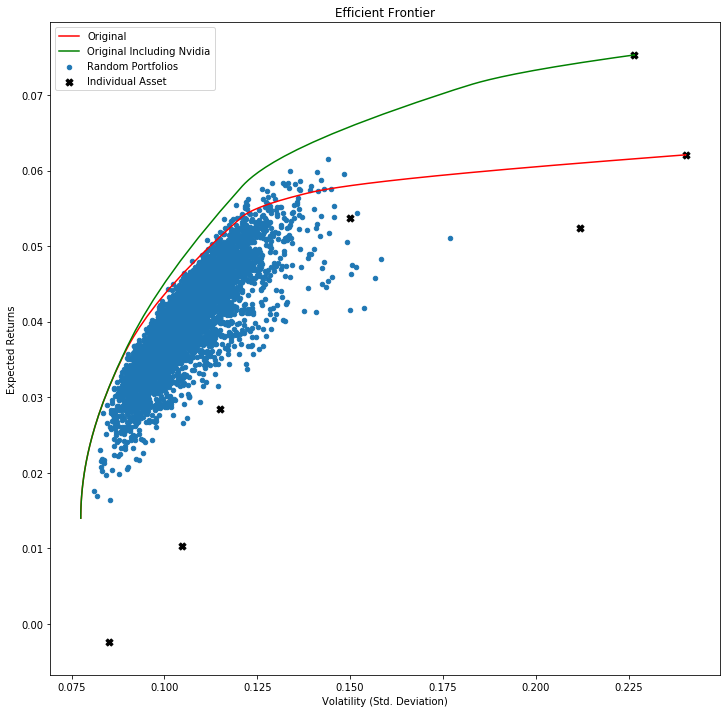

In [71]:
stock_data = pd.read_csv('csv/sample_data/stock_data.csv')


companies = list(stock_data.columns[1:])
quarterly_returns = stock_data[companies].pct_change()

expected_returns = quarterly_returns.mean()
quarterly_cov = quarterly_returns.cov()
portfolios = generate_portfolios(expected_returns, quarterly_cov)

weights, returns, risks = optimal_portfolio(quarterly_returns[1:])


stock_data_nvidia = pd.read_csv('csv/sample_data/stock_data_nvidia.csv')
companies_n = list(stock_data_nvidia.columns[1:])
quarterly_returns_n = stock_data_nvidia[companies_n].pct_change() 

expected_returns_n = quarterly_returns_n.mean()
quarterly_cov_n = quarterly_returns_n.cov()
portfolios_n = generate_portfolios(expected_returns_n, quarterly_cov_n)

weights_n, returns_n, risks_n = optimal_portfolio(quarterly_returns_n[1:])

portfolios_n.plot.scatter(x='Volatility', y='Returns', figsize = (12,12))
plt.plot(risks, returns, color = 'red')
plt.plot(risks_n, returns_n, color = 'green')
plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')

print(stock_data)
print(stock_data.shape)
print(stock_data.columns)
print(stock_data.index)


single_asset_std=np.sqrt(np.diagonal(quarterly_cov_n))
plt.scatter(single_asset_std,expected_returns_n,marker='X',color='black',s=50)


plt.legend(['Original', 'Original Including Nvidia', 'Random Portfolios', 'Individual Asset'])

plt.show()


### Observation

Nvidia is a high-risk, high-return asset, unsurprisngly the expected returns on the new efficient frontier (green) are greater than the original.However the volatility is never increased at any point of expected returns. 

Theory to move the efficient frontier while still including all existing options, a low correlation or best yet uncorrelated asset to the current portfolio, unlike expected return, risk of an individual asset does not indicate whether it will affect the risk of the overall portfolio. 

At the highest potential expected return on both of the Efficient Frontier's lies a single black X. This illustrates that a portfolio that maximizes returns at all costs will simply invest entirely into the highest return and generally highest risk stock?

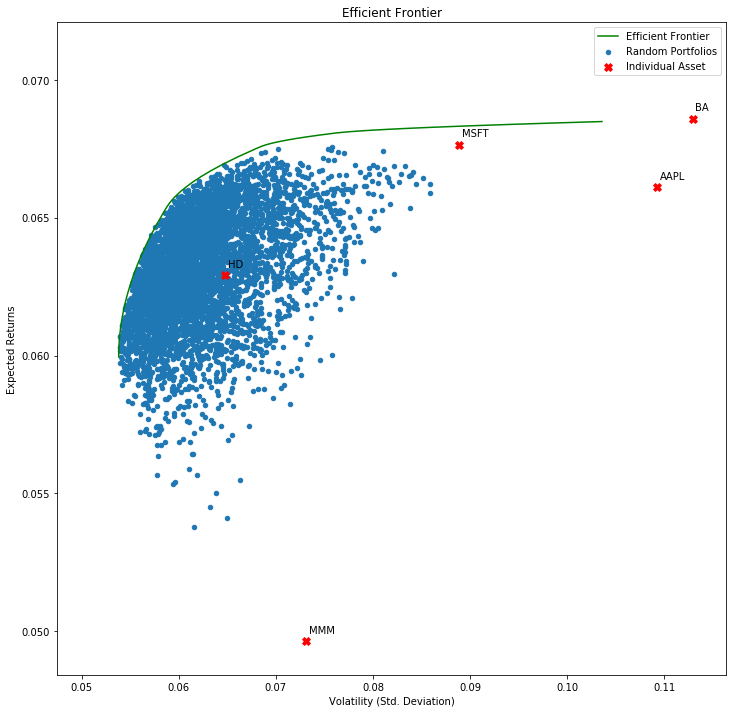

In [94]:
def processStockDataMOV(tickers, start_date = None, end_date = None, collapse = None):
    dfList, keyList = aggregateStockData(tickers, start_date = start_date, end_date = end_date, collapse = 'quarterly')
    if dfList == None:
        return None
    
    l = []
    
    def process(df):
        x = df.Adj_Close
        return x
    
    
    for df,key in zip(dfList, keyList):
        t = process(df)
        l.append(t)
    
        
    
    r = pd.concat(l, axis = 1)
    r.columns = keyList
    r.reset_index(inplace = True)
    return r


def createMOV(tickers, start_date = None, end_date = None, collapse = None):
    stock_data = processStockDataMOV(tickers, start_date = start_date, end_date = end_date, collapse = collapse)
    companies = list(stock_data.columns[1:])
    quarterly_returns = stock_data[companies].pct_change()
    expected_returns = quarterly_returns.mean()
    
    cov = quarterly_returns.cov()
    portfolios = generate_portfolios(expected_returns, cov)
    weights, returns, risks = optimal_portfolio(quarterly_returns[1:])
    
    #random portffolios
    portfolios.plot.scatter(x='Volatility', y='Returns', figsize = (12,12))
    #efficient frontier
    plt.plot(risks, returns, color = 'green')
    
    
    plt.xlabel('Volatility (Std. Deviation)')
    plt.ylabel('Expected Returns')
    plt.title('Efficient Frontier')

    
    #Individual
    single_asset_std=np.sqrt(np.diagonal(cov))
    plt.scatter(single_asset_std,expected_returns,marker='X',color='red',s=60)
    
    
    for i, txt in enumerate(tickers):
        plt.annotate(txt, (single_asset_std[i] +0.0003, expected_returns[i] + 0.0003))
    
    
    plt.legend(['Efficient Frontier', 'Random Portfolios', 'Individual Asset'])
    plt.show()
    
    
    
    

createMOV(['AAPL', 'MSFT', 'HD', 'BA', 'MMM'])


# Visualizing Relative Correlations

In [25]:
from matplotlib import style
pd.options.display.float_format = '{:.5f}'.format
start = datetime(2010, 1, 1)
end = datetime(2017, 1, 11)


dfcomp = data.DataReader(['AAPL', 'GE', 'GOOG', 'IBM', 'MSFT'],'yahoo',start=start,end=end)['Adj Close']


In [26]:
dfcomp

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2010-01-04,26.46684,10.87446,312.20477,94.72456,24.29437
2010-01-05,26.51260,10.93077,310.82993,93.58028,24.30222
2010-01-06,26.09088,10.87446,302.99429,92.97238,24.15307
2010-01-07,26.04265,11.43754,295.94073,92.65054,23.90189
2010-01-08,26.21579,11.68389,299.88596,93.58028,24.06673
...,...,...,...,...,...
2017-01-05,110.82955,27.92664,794.02002,144.78818,58.86871
2017-01-06,112.06511,28.00638,806.15002,145.50053,59.37897
2017-01-09,113.09156,27.87348,806.65002,143.88699,59.18999


In [27]:
retscomp = dfcomp.pct_change()

retscomp

Symbols,AAPL,GE,GOOG,IBM,MSFT
Date,,,,,
2010-01-04,nan,nan,nan,nan,nan
2010-01-05,0.00173,0.00518,-0.00440,-0.01208,0.00032
2010-01-06,-0.01591,-0.00515,-0.02521,-0.00650,-0.00614
2010-01-07,-0.00185,0.05178,-0.02328,-0.00346,-0.01040
2010-01-08,0.00665,0.02154,0.01333,0.01004,0.00690
...,...,...,...,...,...
2017-01-05,0.00509,-0.00568,0.00905,-0.00331,0.00000
2017-01-06,0.01115,0.00286,0.01528,0.00492,0.00867
2017-01-09,0.00916,-0.00475,0.00062,-0.01109,-0.00318


In [28]:
corr = retscomp.corr()
corr

Symbols,AAPL,GE,GOOG,IBM,MSFT
Symbols,,,,,
AAPL,1.00000,0.38150,0.41169,0.38384,0.39347
GE,0.38150,1.00000,0.42230,0.53517,0.47407
GOOG,0.41169,0.42230,1.00000,0.40301,0.47208
IBM,0.38384,0.53517,0.40301,1.00000,0.49667
MSFT,0.39347,0.47407,0.47208,0.49667,1.00000


Text(0, 0.5, 'Returns GE')

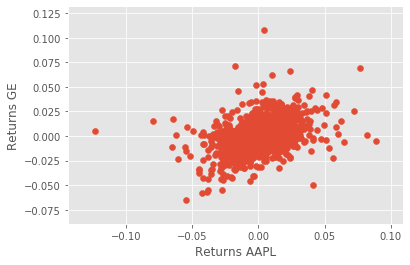

In [30]:
style.use('ggplot')

plt.scatter(retscomp.AAPL, retscomp.GE)

plt.xlabel('Returns AAPL')
plt.ylabel('Returns GE')

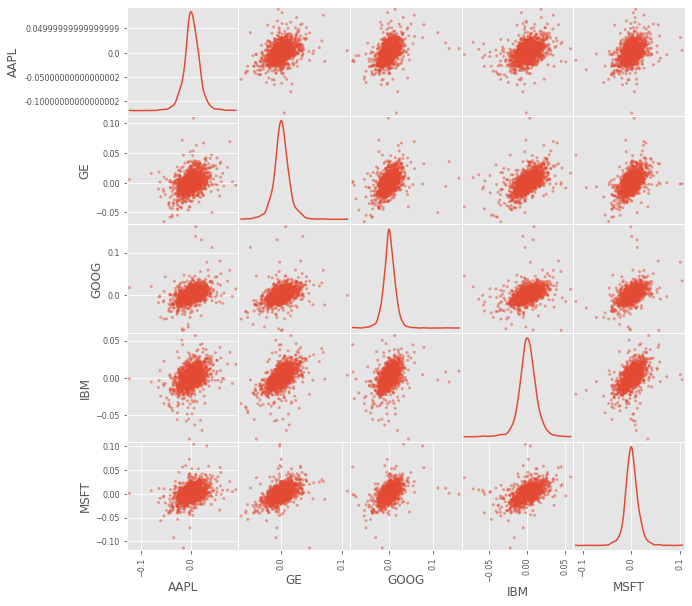

In [32]:
pd.plotting.scatter_matrix(retscomp, diagonal='kde', figsize=(10, 10));

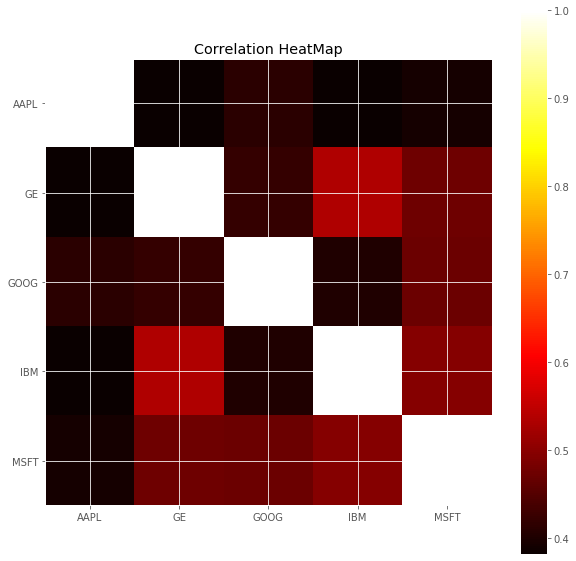

In [37]:
plt.figure(figsize = (10,10))
plt.imshow(corr, cmap='hot', interpolation='none')
plt.colorbar()
plt.title('Correlation HeatMap')
plt.xticks(range(len(corr)), corr.columns)
plt.yticks(range(len(corr)), corr.columns);